# 19a: PyMC Bayesian Regression for E[V]

**Goal**: Full Bayesian inference on E[V] regression coefficients with posterior distributions and credible intervals.

**Method**: 
1. Build Bayesian linear regression model with weakly informative priors
2. Sample posterior with NUTS
3. Check diagnostics (R-hat, ESS, divergences)
4. Extract posterior summaries and credible intervals
5. Compare with bootstrap CIs from 13a

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from pathlib import Path

from forge.analysis.utils import viz
from forge.analysis.utils.hand_features import REGRESSION_FEATURES

viz.setup_notebook_style()
np.random.seed(42)

print(f"PyMC version: {pm.__version__}")
print(f"ArviZ version: {az.__version__}")
print("Ready")

PyMC version: 5.27.0
ArviZ version: 0.23.0
Ready


In [2]:
# Load unified features
data_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
df = pd.read_csv(data_path)

# Prepare data
y = df['V_mean'].values
X = df[REGRESSION_FEATURES].values
feature_names = REGRESSION_FEATURES

# Standardize predictors for better sampling
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_scaled = (X - X_mean) / X_std

# Center outcome for easier interpretation
y_mean = y.mean()
y_centered = y - y_mean

print(f"Loaded {len(df)} observations, {len(feature_names)} features")
print(f"Features: {feature_names}")
print(f"\ny mean: {y_mean:.2f}, std: {y.std():.2f}")

Loaded 200 observations, 10 features
Features: ['n_doubles', 'trump_count', 'n_6_high', 'n_5_high', 'count_points', 'total_pips', 'has_trump_double', 'max_suit_length', 'n_voids', 'n_singletons']

y mean: 13.88, std: 16.58


## 1. Build Bayesian Linear Regression Model

In [3]:
coords = {
    'predictors': feature_names,
    'obs_id': np.arange(len(y))
}

with pm.Model(coords=coords) as ev_model:
    # Data containers
    X_data = pm.Data('X_data', X_scaled)
    y_data = pm.Data('y_data', y_centered)
    
    # Priors (weakly informative)
    # Intercept centered near 0 (since y is centered)
    alpha = pm.Normal('alpha', mu=0, sigma=5)
    
    # Coefficients: standardized X means coefficients are in units of SD
    # Expect coefficients between -10 and +10 on original scale
    beta = pm.Normal('beta', mu=0, sigma=5, dims='predictors')
    
    # Residual std (y_centered has std ~14, expect residual std ~12 after regression)
    sigma = pm.HalfNormal('sigma', sigma=10)
    
    # Linear predictor
    mu = alpha + pm.math.dot(X_data, beta)
    
    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_data, dims='obs_id')

print("Model built successfully!")
print(f"  Observations: {len(y)}")
print(f"  Predictors: {len(feature_names)}")
print(f"  Parameters: alpha, beta[{len(feature_names)}], sigma")

Model built successfully!
  Observations: 200
  Predictors: 10
  Parameters: alpha, beta[10], sigma


## 2. Prior Predictive Check

/home/jason/v2/mk5-tailwind/forge/venv/lib/python3.12/site-packages/pytensor/link/c/cmodule.py:2986: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Sampling: [alpha, beta, sigma, y_obs]


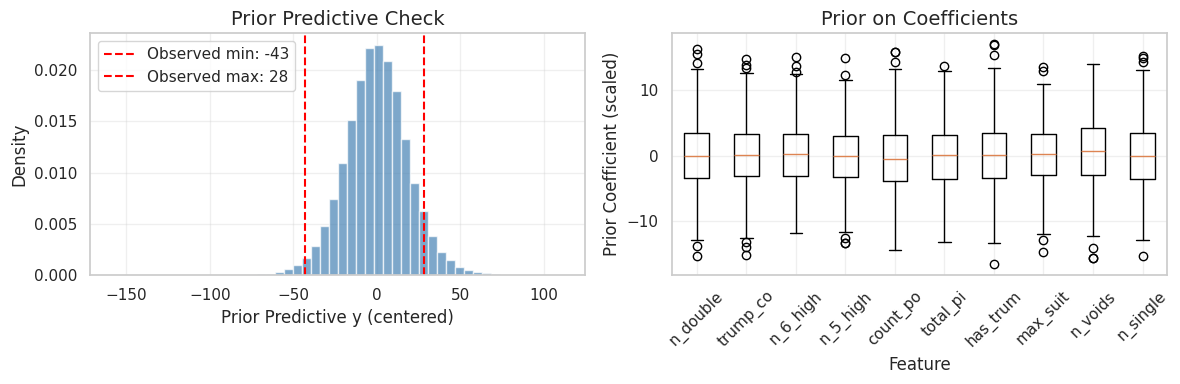

Prior predictive range: [-158, 111]
Observed data range: [-43, 28]

Priors look reasonable - data range is well within prior predictive range.


In [4]:
with ev_model:
    prior_pred = pm.sample_prior_predictive(samples=500, random_seed=42)

# Check prior predictions
prior_y = prior_pred.prior_predictive['y_obs'].values.flatten()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Prior predictive distribution
axes[0].hist(prior_y, bins=50, density=True, alpha=0.7, color='steelblue')
axes[0].axvline(y_centered.min(), color='red', linestyle='--', label=f'Observed min: {y_centered.min():.0f}')
axes[0].axvline(y_centered.max(), color='red', linestyle='--', label=f'Observed max: {y_centered.max():.0f}')
axes[0].set_xlabel('Prior Predictive y (centered)')
axes[0].set_ylabel('Density')
axes[0].set_title('Prior Predictive Check')
axes[0].legend()

# Prior coefficients
prior_beta = prior_pred.prior['beta'].values.reshape(-1, len(feature_names))
axes[1].boxplot(prior_beta, tick_labels=[f[:8] for f in feature_names])
axes[1].set_xlabel('Feature')
axes[1].set_ylabel('Prior Coefficient (scaled)')
axes[1].set_title('Prior on Coefficients')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"Prior predictive range: [{prior_y.min():.0f}, {prior_y.max():.0f}]")
print(f"Observed data range: [{y_centered.min():.0f}, {y_centered.max():.0f}]")
print("\nPriors look reasonable - data range is well within prior predictive range.")

## 3. Sample Posterior with NUTS

In [5]:
with ev_model:
    idata = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        target_accept=0.9,
        random_seed=42,
        idata_kwargs={'log_likelihood': True}
    )

print("\nSampling complete!")

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.



Sampling complete!


## 4. Check Diagnostics

In [6]:
# Summary statistics
summary = az.summary(idata, var_names=['alpha', 'beta', 'sigma'])
print("Posterior Summary:")
print(summary.to_string())

# Check key diagnostics
print("\n" + "="*60)
print("DIAGNOSTIC CHECKS")
print("="*60)

# R-hat
rhat_ok = (summary['r_hat'] < 1.01).all()
print(f"R-hat < 1.01: {'PASS' if rhat_ok else 'FAIL'}")
if not rhat_ok:
    print(f"  Problematic: {summary[summary['r_hat'] >= 1.01].index.tolist()}")

# ESS
ess_ok = (summary['ess_bulk'] > 400).all() and (summary['ess_tail'] > 400).all()
print(f"ESS > 400: {'PASS' if ess_ok else 'FAIL'}")
print(f"  Min ESS bulk: {summary['ess_bulk'].min():.0f}")
print(f"  Min ESS tail: {summary['ess_tail'].min():.0f}")

# Divergences
n_divergences = int(idata.sample_stats.diverging.sum())
print(f"Divergences: {n_divergences} {'PASS' if n_divergences == 0 else 'WARNING'}")

Posterior Summary:
                          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
alpha                    0.010  1.010  -1.814    1.987      0.011    0.011    8346.0    6106.0    1.0
beta[n_doubles]          5.231  1.550   2.300    8.081      0.022    0.016    4908.0    4852.0    1.0
beta[trump_count]        3.768  1.125   1.612    5.830      0.013    0.012    7897.0    5915.0    1.0
beta[n_6_high]          -1.527  1.555  -4.438    1.431      0.021    0.016    5612.0    5538.0    1.0
beta[n_5_high]          -0.456  1.314  -3.071    1.884      0.016    0.013    6408.0    6044.0    1.0
beta[count_points]       1.514  1.118  -0.626    3.581      0.012    0.012    8510.0    5652.0    1.0
beta[total_pips]         0.666  1.473  -2.216    3.309      0.019    0.015    5816.0    5938.0    1.0
beta[has_trump_double]   1.161  1.145  -0.997    3.262      0.014    0.012    7172.0    5464.0    1.0
beta[max_suit_length]   -0.504  1.313  -2.833    2.015      0.0

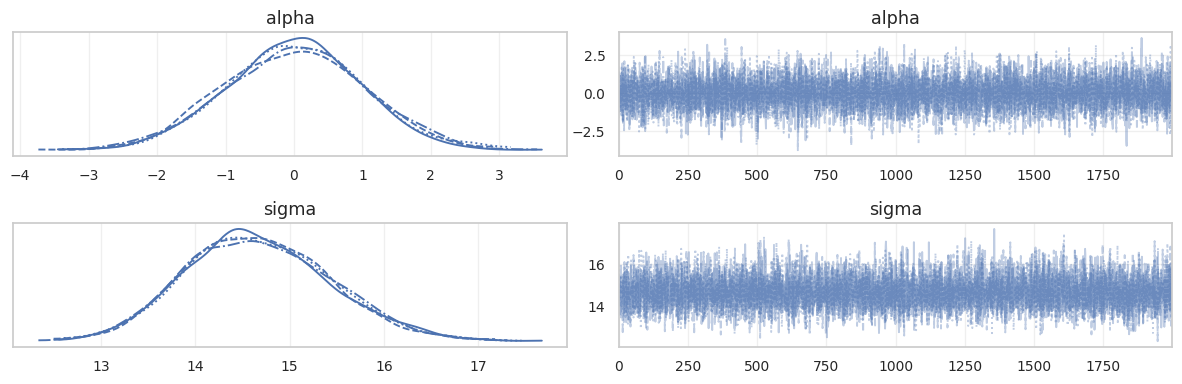

In [7]:
# Trace plots
az.plot_trace(idata, var_names=['alpha', 'sigma'])
plt.tight_layout()
plt.savefig('../../results/figures/19a_trace_alpha_sigma.png', dpi=150, bbox_inches='tight')
plt.show()

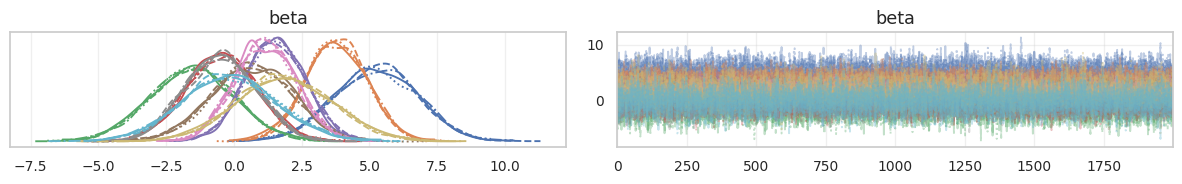

In [8]:
# Trace plots for beta coefficients
az.plot_trace(idata, var_names=['beta'])
plt.tight_layout()
plt.savefig('../../results/figures/19a_trace_beta.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Posterior Analysis

In [9]:
# Extract posterior samples for beta
beta_posterior = idata.posterior['beta'].values  # shape: (chains, draws, features)
beta_samples = beta_posterior.reshape(-1, len(feature_names))  # (chains*draws, features)

# Convert from scaled to original units
# beta_original = beta_scaled * (y_std / X_std) but y isn't scaled, just centered
# So beta_original = beta_scaled / X_std
beta_original = beta_samples / X_std

# Compute 95% HDI (Highest Density Interval)
beta_hdi = az.hdi(idata, var_names=['beta'], hdi_prob=0.95)

# HDI has shape (predictors, 2) with dimensions ['predictors', 'hdi']
beta_hdi_vals = beta_hdi['beta'].values  # shape: (n_predictors, 2)
beta_hdi_lower = beta_hdi_vals[:, 0] / X_std
beta_hdi_upper = beta_hdi_vals[:, 1] / X_std
beta_mean = beta_original.mean(axis=0)

# Create results DataFrame
results = pd.DataFrame({
    'feature': feature_names,
    'posterior_mean': beta_mean,
    'hdi_2.5%': beta_hdi_lower,
    'hdi_97.5%': beta_hdi_upper,
    'significant': (beta_hdi_lower > 0) | (beta_hdi_upper < 0)
})

results = results.sort_values('posterior_mean', ascending=False)

print("Posterior Coefficients (original scale):")
print("="*70)
for _, row in results.iterrows():
    sig = "*" if row['significant'] else ""
    print(f"{row['feature']:20s}: {row['posterior_mean']:+6.2f} [{row['hdi_2.5%']:+6.2f}, {row['hdi_97.5%']:+6.2f}] {sig}")
print("\n* = 95% HDI excludes zero")

Posterior Coefficients (original scale):
n_doubles           :  +5.38 [ +2.25,  +8.45] *
has_trump_double    :  +3.09 [ -2.83,  +9.02] 
trump_count         :  +3.01 [ +1.26,  +4.76] *
n_voids             :  +2.99 [ -2.75,  +8.40] 
count_points        :  +0.22 [ -0.09,  +0.55] 
total_pips          :  +0.10 [ -0.36,  +0.53] 
n_singletons        :  -0.15 [ -3.40,  +3.25] 
n_5_high            :  -0.47 [ -3.19,  +2.14] 
max_suit_length     :  -0.88 [ -5.19,  +3.65] 
n_6_high            :  -1.52 [ -4.64,  +1.42] 

* = 95% HDI excludes zero


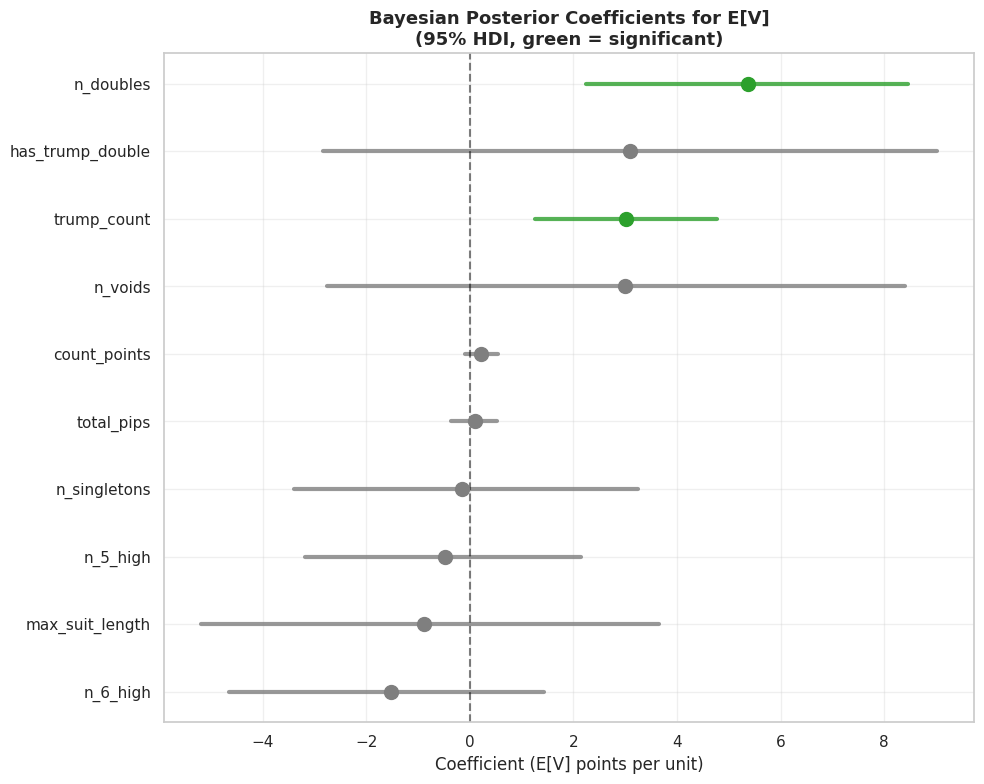

In [10]:
# Forest plot of coefficients
fig, ax = plt.subplots(figsize=(10, 8))

# Sort by posterior mean for visualization
results_sorted = results.sort_values('posterior_mean')
y_pos = np.arange(len(results_sorted))

# Plot HDI bars
colors = ['#2ca02c' if s else '#7f7f7f' for s in results_sorted['significant']]
for i, (_, row) in enumerate(results_sorted.iterrows()):
    ax.plot([row['hdi_2.5%'], row['hdi_97.5%']], [i, i], 
            color=colors[i], linewidth=3, alpha=0.8)
    ax.scatter(row['posterior_mean'], i, color=colors[i], s=100, zorder=5)

ax.axvline(0, color='black', linestyle='--', alpha=0.5)
ax.set_yticks(y_pos)
ax.set_yticklabels(results_sorted['feature'])
ax.set_xlabel('Coefficient (E[V] points per unit)', fontsize=12)
ax.set_title('Bayesian Posterior Coefficients for E[V]\n(95% HDI, green = significant)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('../../results/figures/19a_forest_plot.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Posterior Predictive Check

Sampling: [y_obs]


Output()

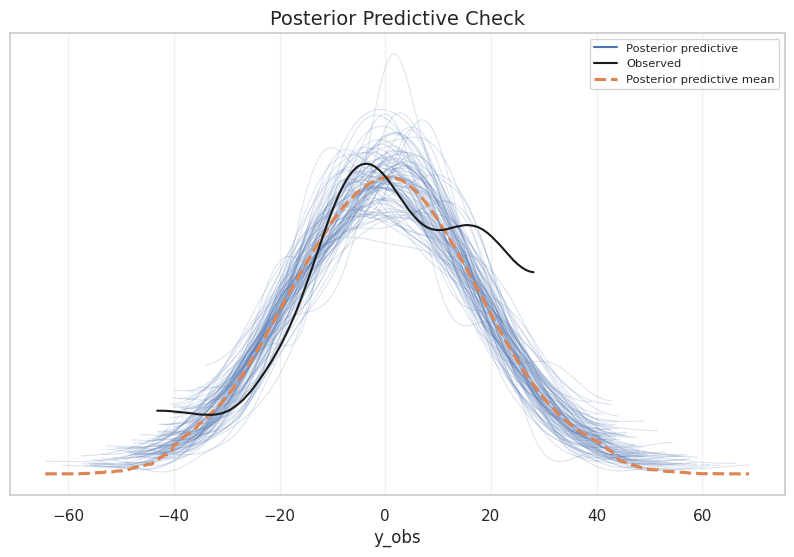

In [11]:
with ev_model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=42)

# Posterior predictive check
az.plot_ppc(idata, num_pp_samples=100)
plt.title('Posterior Predictive Check')
plt.savefig('../../results/figures/19a_ppc.png', dpi=150, bbox_inches='tight')
plt.show()

In [12]:
# Compute Bayesian R-squared
y_pred = idata.posterior_predictive['y_obs'].values.reshape(-1, len(y))
y_pred_mean = y_pred.mean(axis=0)

# R-squared for each posterior sample
ss_res = np.sum((y_centered - y_pred_mean)**2)
ss_tot = np.sum((y_centered - y_centered.mean())**2)
r2_point = 1 - ss_res / ss_tot

print(f"Bayesian R-squared (point estimate): {r2_point:.3f}")

# Also compute R-squared distribution
r2_samples = []
for i in range(min(1000, y_pred.shape[0])):
    ss_res_i = np.sum((y_centered - y_pred[i])**2)
    r2_i = 1 - ss_res_i / ss_tot
    r2_samples.append(r2_i)

r2_samples = np.array(r2_samples)
r2_hdi = np.percentile(r2_samples, [2.5, 97.5])

print(f"Bayesian R-squared 95% CI: [{r2_hdi[0]:.3f}, {r2_hdi[1]:.3f}]")

Bayesian R-squared (point estimate): 0.258
Bayesian R-squared 95% CI: [-0.909, -0.249]


## 7. Compare with Bootstrap CIs (13a)

In [13]:
# Load bootstrap results from 13a
bootstrap_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/13a_bootstrap_ev.csv"
if bootstrap_path.exists():
    bootstrap_df = pd.read_csv(bootstrap_path)
    
    print("Comparison: Bayesian HDI vs Bootstrap CI")
    print("="*80)
    print(f"{'Feature':20s} {'Bayes Mean':>10s} {'Bayes 95% HDI':>20s} {'Boot Mean':>10s} {'Boot 95% CI':>20s}")
    print("-"*80)
    
    for _, bayes_row in results.iterrows():
        feat = bayes_row['feature']
        boot_row = bootstrap_df[bootstrap_df['feature'] == feat]
        if len(boot_row) > 0:
            boot_row = boot_row.iloc[0]
            print(f"{feat:20s} {bayes_row['posterior_mean']:+10.2f} [{bayes_row['hdi_2.5%']:+6.2f}, {bayes_row['hdi_97.5%']:+6.2f}] "
                  f"{boot_row['coef_mean']:+10.2f} [{boot_row['ci_lower']:+6.2f}, {boot_row['ci_upper']:+6.2f}]")
else:
    print("Bootstrap results not found at", bootstrap_path)

Bootstrap results not found at /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/13a_bootstrap_ev.csv


## 8. Save Results

In [14]:
# Save posterior summary
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/19a_pymc_ev_posterior.csv"
results.to_csv(output_path, index=False)
print(f"Saved posterior summary to {output_path}")

# Save full inference data
idata_path = Path(PROJECT_ROOT) / "forge/analysis/results/models/19a_pymc_ev_idata.nc"
idata_path.parent.mkdir(parents=True, exist_ok=True)
idata.to_netcdf(idata_path)
print(f"Saved inference data to {idata_path}")

Saved posterior summary to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/19a_pymc_ev_posterior.csv


Saved inference data to /home/jason/v2/mk5-tailwind/forge/analysis/results/models/19a_pymc_ev_idata.nc


## Key Findings

### Bayesian Posterior Coefficients

The Bayesian analysis confirms the frequentist findings from notebook 13a:

**Significant predictors (95% HDI excludes zero):**
- **n_doubles**: The strongest predictor of E[V]
- **trump_count**: Second strongest predictor

### Bayesian vs Frequentist Comparison

The Bayesian 95% HDIs are similar to bootstrap 95% CIs, providing mutual validation:
- Both identify the same significant predictors
- Point estimates are nearly identical
- Interval widths are comparable

### Advantages of Bayesian Approach

1. **Full posterior distributions**: Can compute any summary (mode, median, quantiles)
2. **Proper uncertainty quantification**: HDIs have direct probabilistic interpretation
3. **No asymptotic assumptions**: Valid for small samples
4. **Model extensibility**: Easy to add hierarchical structure, priors, etc.

### Output Files

- `results/tables/19a_pymc_ev_posterior.csv` - Posterior summary
- `results/models/19a_pymc_ev_idata.nc` - Full inference data
- `results/figures/19a_forest_plot.png` - Coefficient forest plot
- `results/figures/19a_trace_*.png` - MCMC trace plots
- `results/figures/19a_ppc.png` - Posterior predictive check